# Read Data


In [25]:
from pathlib import Path
from PIL import Image
import numpy as np

In [26]:
data_path = Path("/home/user/data")
train_data_path = data_path / "ML" / "train"
test_data_path = data_path / "test"

In [27]:
img_height = 180
img_width  = 180
image_size = (img_height, img_width)

In [28]:
# lower number of pixels
image_size

(180, 180)

# One Image to vector of 0-1 values

In [29]:
image = Image.open(train_data_path / 'target_1' / 'tumor_0_10_2921.jpg')

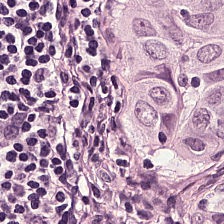

In [30]:
image.show()

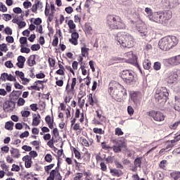

In [31]:
image.resize(image_size) # 90 x 90

In [32]:
image_arr = np.array(image.resize(image_size))/255
image_arr.shape

(180, 180, 3)

In [33]:
# Every image as one vector
image_arr.flatten().shape

(97200,)

# All images and labels for training data

In [34]:
train_list = []
label_list = []
for directory in list(train_data_path.iterdir()):
    files = list(directory.glob('*.jpg'))
    
    print('Directory: ' + directory.as_posix() + ' (' + str(len(files)) + ' files)')
    
    # Get labels from directory name (0 = normal, 1 = tumor)
    label  = int(directory.as_posix()[-1])
    labels = np.repeat(label, len(files))
    label_list.append(labels)
   
    # 1-dim flattened array per image (feature length = 24300)
    arr = np.array([(np.array(Image.open(file).resize(image_size)) / 255).flatten() for file in files])
    train_list.append(arr)

Directory: /home/user/data/ML/train/target_1 (1382 files)
Directory: /home/user/data/ML/train/target_0 (3618 files)


In [35]:
# merge the two train image matrices into one
X = np.concatenate((train_list[0], train_list[1]))
X.shape

(5000, 97200)

In [36]:
# merge the output labels vectors into one 
Y = np.concatenate((label_list[0], label_list[1]))
Y.shape

(5000,)

# Images and labels for test data

In [37]:
test_list = []
test_label_list = []
test_files_list = []
for directory in list(test_data_path.iterdir()):
    files = list(directory.glob('*.jpg'))
    
    print('Directory: ' + directory.as_posix() + ' (' + str(len(files)) + ' files)')
    
    # Get labels from directory name (0 = normal, 1 = tumor)
    label  = int(directory.as_posix()[-1])
    labels = np.repeat(label, len(files))
    test_label_list.append(labels)
   
    # 1-dim flattened array per image (feature length = 24300)
    arr = np.array([(np.array(Image.open(file).resize(image_size)) / 255).flatten() for file in files])
    test_list.append(arr)
    
    # keep file names in a list
    test_files_list.append([file.as_posix() for file in files])

Directory: /home/user/data/test/target_1 (2751 files)
Directory: /home/user/data/test/target_0 (3249 files)


In [38]:
file_paths = test_files_list[0] + test_files_list[1]

In [39]:
len(file_paths)

6000

In [40]:
# merge the two test image matrices into one
X_test = np.concatenate((test_list[0], test_list[1]))
X_test.shape

(6000, 97200)

In [41]:
# merge the output labels vectors into one 
Y_test = np.concatenate((test_label_list[0], test_label_list[1]))
Y_test.shape

(6000,)

# Random Forest Classifier 

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [43]:
rfcl = RandomForestClassifier(n_estimators = 500, random_state = 42, n_jobs = -1, verbose = 1)
rfcl.fit(X, Y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   54.9s finished


RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42, verbose=1)

In [44]:
pred = rfcl.predict_proba(X_test)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 500 out of 500 | elapsed:    0.3s finished


In [45]:
pred.shape

(6000, 2)

In [46]:
roc_auc_score(Y_test, pred[:,1])

0.7713446824059835

In [47]:
import pandas as pd

df_submission = pd.DataFrame(data={'file_paths': file_paths, 'predictions': pred[:,1]})
df_submission["file_paths"] = df_submission["file_paths"].apply(lambda x: x.replace("/home/user/data/test","/data/challenges_data/test"))

In [48]:
df_submission.to_csv('rf_results_180.csv', index=False)
df_submission.head()

,file_paths,predictions
0,/data/challenges_data/test/target_1/tumor_cent...,0.774
1,/data/challenges_data/test/target_1/tumor_cent...,0.800
2,/data/challenges_data/test/target_1/tumor_cent...,0.718
3,/data/challenges_data/test/target_1/tumor_cent...,0.794
4,/data/challenges_data/test/target_1/tumor_cent...,0.654
